<p align="center">
    <img src="images/RFM-CLTV.png" alt="drawing" width="1000"/>

# Import libraries

In [265]:
import warnings
warnings.filterwarnings("ignore")

In [266]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# # Basic libraries
# 
import pandas as pd
import numpy as np
import datetime as dt

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# Visualization libraries
#
import matplotlib.pyplot as plt
import seaborn           as sns

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# Sklearn library
#
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster       import KMeans

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# Feature engine library
#
import feature_engine
from   feature_engine.outliers import Winsorizer


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# User library
#
from   utils.snake_plot import *
from   utils.check_skew import *

# Import data

In [267]:
# Load Dataset
#
df = pd.read_csv('Data/OnlineRetail.csv', encoding="ISO-8859-1")

print('[INFO] Number of instances: ', df.shape[0])
print('[INFO] Number of features:  ', df.shape[1])

# Visualize DataFrame
#
df.head( 3 )

[INFO] Number of instances:  541909
[INFO] Number of features:   8


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,1/12/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1/12/10 8:26,2.75,17850.0,United Kingdom


## Data Pre-processing

**Observations/Findings:**

- The min and max value for Quantity is 80995, this could represent cancelled or returned orders.
- The UnitPrice also have few negative values which is uncommon,these transactions could represent cancelled orders by customers or bad-debt incurred by the business.
- Bad debt adjustments will be dropped from the dataset as these do not represent actual sales. 

We need to clean the above values by removing from the dataset


- There are almost 25% missing CustomerID. We need to remove them as there is no way we can get the number of CustomerID
- As customer clusters may vary by geography, we will restrict the data to only United Kingdom customers, which contains most of our customers historical data (~90%).

In [268]:
# More than 90% of customers are 'United Kingdom' customers.
#
df = df[df.Country == 'United Kingdom']

In [269]:
# Removing the negative values from UnitPrice and Quantity
#
df = df[df[ 'Quantity'  ] > 0]
df = df[df[ 'UnitPrice' ] > 0]

# Removing the Null values from the data.
#
df = df[ pd.notnull(df['CustomerID']) ]

In [270]:
# Replace 'InvoiceDate' to 'Date'
#
df = df.rename(columns = {'InvoiceDate': 'Date'})

# Convert 'Date' to datetime64
#
df[ 'Date' ] = df[ 'Date' ].astype( 'datetime64' )


In [271]:
# Convert 'CustomerID' to int
#
df[ 'CustomerID' ] = df[ 'CustomerID' ].astype( 'int' )

**Note:** We have all the crucial information we need

- Customer ID
- Unit Price
- Quantity
- Invoice Date

### Calculate Revenue

In [272]:
# Revenue = Order Count * Average Revenue per Order
#
df['Revenue'] = df['Quantity'] * df['UnitPrice']

## Aggregating the Orders by Month

In [273]:
df_agg = df.resample('M', on = 'Date').sum()

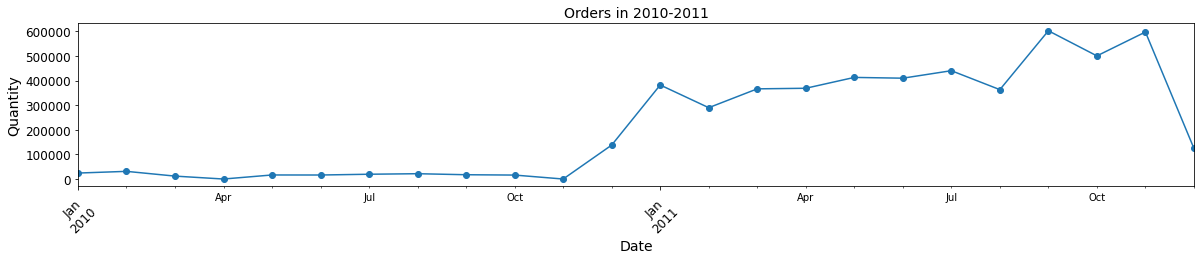

In [274]:
df_agg[ 'Quantity' ].plot(color='tab:Blue', marker='o', figsize = (20, 3))


plt.title('Orders in 2010-2011', size = 14)
#
plt.xticks(rotation = 45, size = 12);
plt.yticks(size = 12)
#
plt.xlabel('Date', size = 14)
plt.ylabel('Quantity', size = 14);
#
plt.legend([], frameon = False)


# RFM Analysis

**Recency-Frequency-Monetary**
    
    
RFM analysis allows you to segment customers by the frequency and value of purchases and identify those customers who spend the most money.

* Recency — how long it’s been since a customer bought something from us
* Frequency — how often a customer buys from us
* Monetary value — the total value of purchases a customer has made

### Keep useful feature for RFM analysis

- CustomerID
- Date
- InvoiceNo
- Revenue

In [275]:
df = df[ ['CustomerID' , 'Date', 'InvoiceNo', 'Revenue'] ]

## Recency

In [276]:
# The last invoice date is 2011–12–11, we will use this date to calculate Recency
NOW = dt.date(2011, 12, 11) 

df['Date'] = pd.DatetimeIndex(df[ 'Date' ]).date

In [277]:
# Create Recency DataFrame
# 
df_Recency         = df.groupby(['CustomerID'], as_index=False)['Date'].max()
df_Recency.columns = ['CustomerID','Last_Purchase_Date']

df_Recency['Recency']   = df_Recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
df_Recency.drop(columns = ['Last_Purchase_Date'], inplace=True)


# Recency DataFrame visualization
#
df_Recency.head( 5 )

,CustomerID,Recency
0,12346,327
1,12347,41
2,12348,77
3,12349,20
4,12350,312


## Frequency

In [278]:
# Create Frequeny DataFrame
#
df_Frequency = df.groupby('CustomerID').agg( {'InvoiceNo' : lambda x: len(x) })
df_Frequency.rename(columns = {'InvoiceNo' : 'Frequency'}, inplace = True)

# Frequeny DataFrame visualization
#
df_Frequency.head( 5 )

,Frequency
CustomerID,
12346,1
12347,182
12348,31
12349,73
12350,17


## Monetarty

In [279]:
# Create Monetarty DataFrame
#
df_Monetarty = df.groupby('CustomerID').agg( {'Revenue' : lambda x: x.sum()} )
df_Monetarty.rename(columns = {'Revenue' : 'Monetary'}, inplace = True)

# Monetarty DataFrame visualization
#
df_Monetarty.head( 5 )

,Monetary
CustomerID,
12346,77183.60
12347,4310.00
12348,1797.24
12349,1757.55
12350,334.40


In [280]:
# Merge Recency, Frequency & Monetary DataFrames
#
RFM = df_Recency.merge(df_Frequency, left_on='CustomerID', right_on='CustomerID')
#
RFM = RFM.merge(df_Monetarty, left_on='CustomerID', right_on='CustomerID')


# RFM DataFrame visualization
#
RFM.head( 5 )

,CustomerID,Recency,Frequency,Monetary
0,12346,327,1,77183.60
1,12347,41,182,4310.00
2,12348,77,31,1797.24
3,12349,20,73,1757.55
4,12350,312,17,334.40


In [281]:
# Frequency - Monetarty could be calculated together using the following code
# ---------------------------------------------------------------------------
#
#
# # df_Frequency_Monetarty = df.groupby('CustomerID').agg({'InvoiceNo'  : lambda x:len(x),
#                                                        'Revenue'    : lambda x:x.sum()})

# df_Frequency_Monetarty.rename(columns = {'InvoiceNo' : 'Frequency',
#                                          'Revenue'   : 'Monetary'},inplace= True)
# df_Frequency_Monetarty.head( 5 )

## Calculate RFM-Scores

**Methodology:** Next, we split the metrics into segments using quantiles. 

We will assign a score from 1 to 4 to each Recency, Frequency and Monetary respectively. 1 is the highest value, and 4 is the lowest value. A final RFM score (Overall Value) is calculated simply by combining individual RFM score numbers.

In [282]:
quantiles = RFM.quantile(q = [0.2, 0.4, 0.6, 0.8])

quantiles = quantiles.to_dict()

In [283]:
def RScore(x, p, d):
    if x <= d[p][0.20]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]: 
        return 3
    elif x <= d[p][0.80]: 
        return 4
    else:
        return 5
    
def FMScore(x, p, d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1

### Calculate R_score, F_score, M_score

In [284]:
# Calculate R_score, F_score, M_score
# 
RFM['R_score'] = RFM['Recency'].apply(RScore,    args = ('Recency',   quantiles))
RFM['F_score'] = RFM['Frequency'].apply(FMScore, args = ('Frequency', quantiles))
RFM['M_score'] = RFM['Monetary'].apply(FMScore,  args = ('Monetary',  quantiles))

### Calculating the RFM_Segment & RFM-score

RFM_Segment = str(R_score) + str(F_score) + str(M_score)
RFM_Score   = R_score + F_score + M_score

In [285]:
# Calculate RFM_Segment
# 
RFM['RFM_Segment'] = RFM.R_score.map(str) + RFM.F_score.map(str) + RFM.M_score.map(str)

# Calculate RFM_Score
#
RFM[ 'RFM_Score' ] = RFM[ 'R_score' ] + RFM[ 'F_score' ] + RFM[ 'M_score' ]

# Sort DataFrame based on RFM-Score
#
RFM.sort_values(by = 'RFM_Score', inplace = True)

In [286]:
# Remove some outliers, namely
# Extreme Monetary, with only one sales and R_score > 1
#
RFM = RFM[ ~( (RFM['Monetary'] > np.quantile(RFM['Monetary'], 0.95)) & (RFM['Frequency'] == 1) & (RFM['R_score'] > 1) ) ]
#
# This could be removed, depending on the selected strategy.

### Visualization 

- DataFrame visualization
- RFM-Segment & RFM-Score bar-plots
- Average Revenue Per User

In [287]:
# RFM DataFrame visualization
#
RFM.head( 5 )

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Segment,RFM_Score
1608,14534,3,519,4447.05,1,1,1,111,3
3155,16655,10,261,3794.52,1,1,1,111,3
4010,17841,1,7847,40991.57,1,1,1,111,3
1584,14503,12,164,3543.26,1,1,1,111,3
1586,14505,19,799,5905.64,1,1,1,111,3


#### RFM-Segment & RFM-Score bar-plots

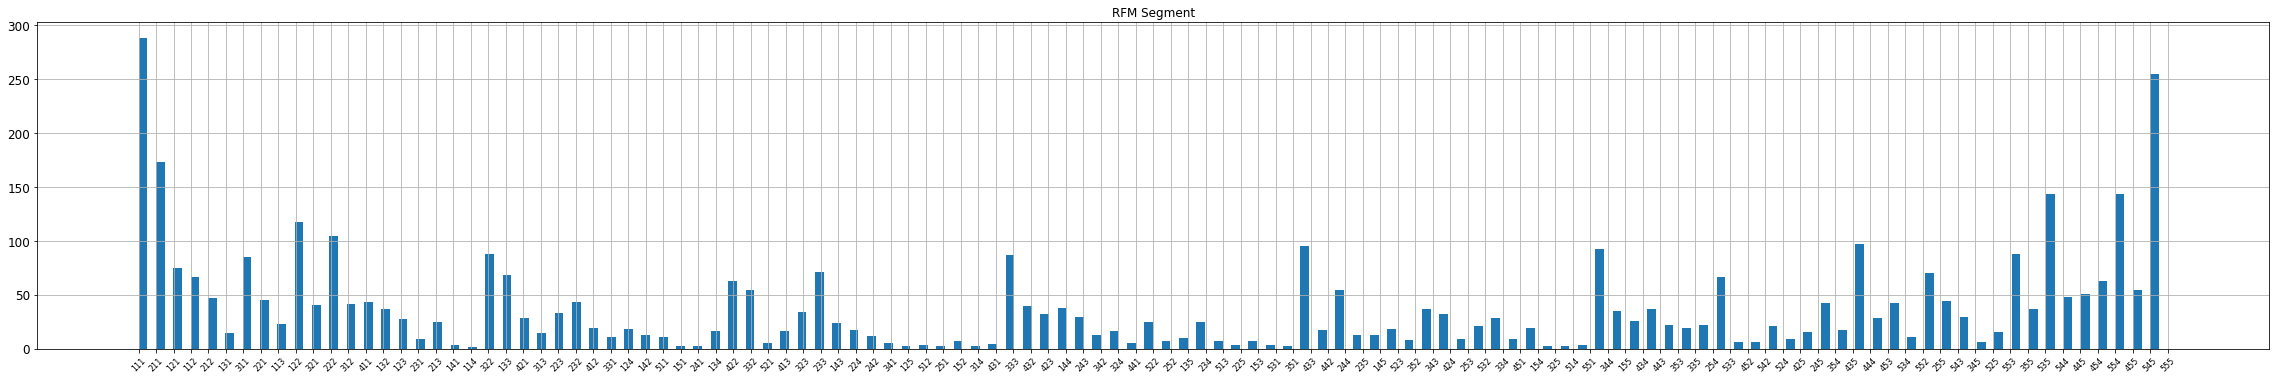

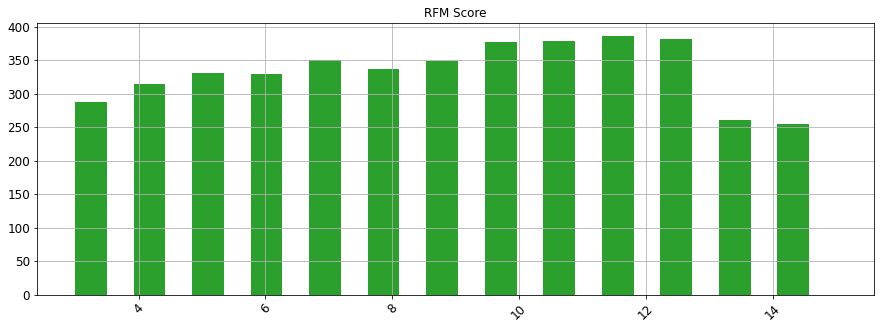

In [288]:
RFM['RFM_Segment'].hist( figsize = (40, 6), bins = RFM.RFM_Segment.nunique(), width = 0.5, color = 'tab:blue')
plt.title('RFM Segment')
plt.xticks(rotation = 45, size = 8);
plt.yticks(size = 12);
plt.show()

RFM['RFM_Score'].hist( figsize = (15, 5), bins = RFM.RFM_Score.nunique(), width = 0.5, color = 'tab:green')
plt.title('RFM Score')
plt.xticks(rotation = 45, size = 12);
plt.yticks(size = 12);
plt.show()


#### Average Revenue Per User

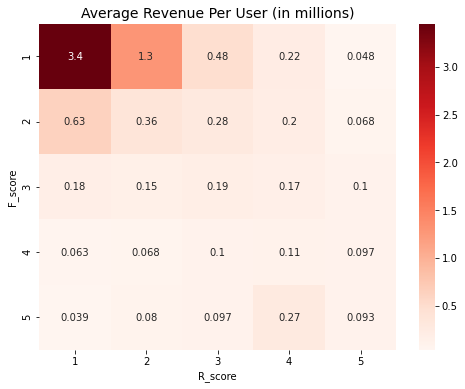

In [289]:
A = RFM.groupby(['R_score', 'F_score']).sum()[['Monetary']].reset_index().pivot('F_score', 'R_score', 'Monetary')


plt.figure( figsize = (8, 6) );
#
sns.heatmap( A / 1.e+6, annot = True, cmap = 'Reds');
plt.title('Average Revenue Per User (in millions)', size = 14);

## Customer characterization

After some calculations on the RFM data we can create customer segments that are actionable and easy to understand — like the ones below:

- **Champions:** Bought recently, buy often and spend the most.
- **Loyal customers:** Buy on a regular basis. Responsive to promotions.
- **Potential loyalist:** Recent customers with average frequency.
- **Recent customers:** Bought most recently, but not often.
- **Promising:** Recent shoppers, but haven’t spent much.
- **Needs attention:** Above average recency, frequency and monetary values. May not have bought very recently though.
- **About to sleep:** Below average recency and frequency. Will lose them if not reactivated.
- **At risk:** Some time since they’ve purchased. Need to bring them back!
- **Can’t lose them:** Used to purchase frequently but haven’t returned for a long time.
- **Hibernating:** Last purchase was long back and low number of orders. May be lost.

**4-class scheme**

<img src="images/Customer_segmentation_4-class.png" alt="drawing" width="500"/>

    
**5-class scheme**

<img src="images/Customer_segmentation_5-class.png" alt="drawing" width="550"/>

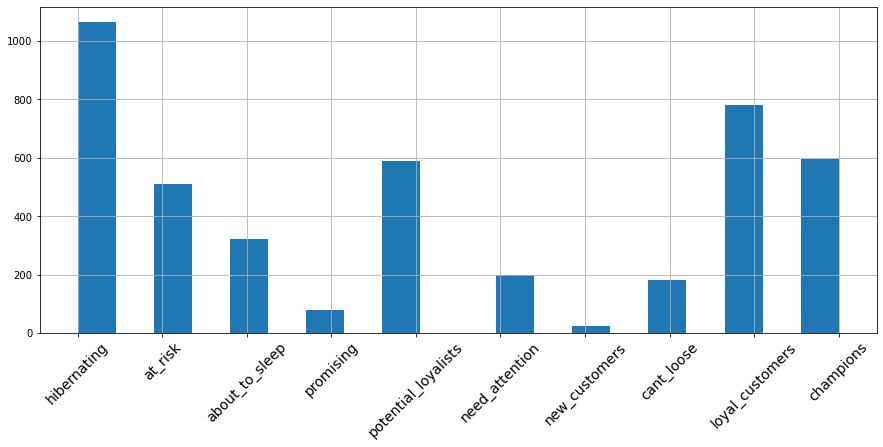

In [290]:
# Create human friendly RFM labels

# Segment map - In case of 4 bins
# segt_map = {
#     r'1[1-2]': 'Hibernating',
#     r'13': 'At risk',
#     r'14': 'Can\'t loose them',
#     r'21': 'About to sleep',
#     r'22': 'Need attention',
#     r'[2-3][3-4]': 'Loyal customers',
#     r'31': 'Promising',
#     r'41': 'New customers',
#     r'[3-4]2': 'Potential loyalists',
#     r'4[3-4]': 'Champions'
# }

# Segment map - In case of 5 bins
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

RFM['Segment'] = RFM['R_score'].map(str) + RFM['F_score'].map(str)
RFM['Segment'] = RFM['Segment'].replace(segt_map, regex=True)

RFM['Segment'].hist( figsize = (15, 6), bins = RFM['Segment'].nunique()*2, color = 'tab:blue')
plt.xticks( size = 14, rotation = 45);

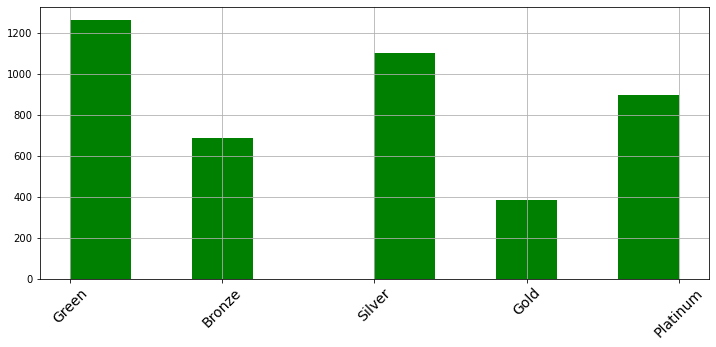

In [296]:
# Create some human friendly labels for the scores
#
RFM[ 'Score' ] = 'Green'
RFM.loc[ RFM['RFM_Score'] >  6, 'Score' ] = 'Bronze' 
RFM.loc[ RFM['RFM_Score'] >  8, 'Score' ] = 'Silver' 
RFM.loc[ RFM['RFM_Score'] > 11, 'Score' ] = 'Gold' 
RFM.loc[ RFM['RFM_Score'] > 12, 'Score' ] = 'Platinum'

# DataFrame visualization
#
RFM[ 'Score' ].hist( figsize = (12, 5));
plt.xticks( size = 14, rotation = 45);

## K-means to perform RFM (Recency, Frequency, and Monetary) customer segmentation. 

### Skewness check

Plotting distribution charts to check for skewness

Recency's: Skew: 1.9180769591770956, : SkewtestResult(statistic=34.995336253782696, pvalue=2.6490580538736686e-268)


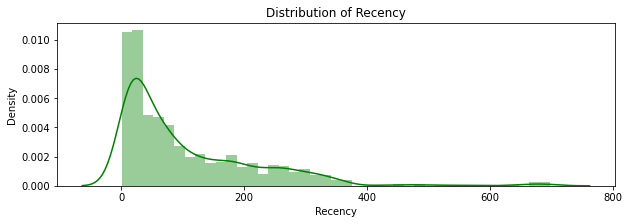

Frequency's: Skew: 18.0985420057334, : SkewtestResult(statistic=83.5492071473737, pvalue=0.0)


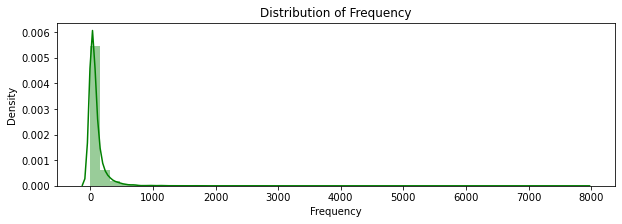

Monetary's: Skew: 19.660283922273187, : SkewtestResult(statistic=85.37228304887486, pvalue=0.0)


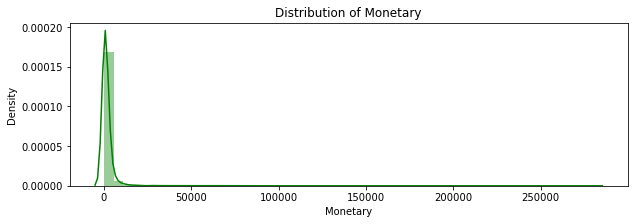

In [297]:
# Plot all Distrubution graphs of Recency, Frequency & Monetary

check_skew(RFM, 'Recency');

check_skew(RFM, 'Frequency');

check_skew(RFM, 'Monetary');

#### Data transformation

The data is highly skewed,therefore we will perform log transformations to reduce the skewness of each variable. I added a small constant as log transformation demands all the values to be positive.

Recency's: Skew: -0.4589403340692929, : SkewtestResult(statistic=-11.790064724456604, pvalue=4.392033687671828e-32)


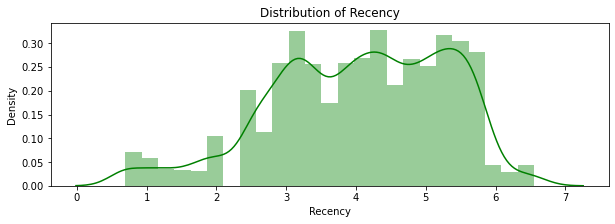

Frequency's: Skew: -0.012419789863428237, : SkewtestResult(statistic=-0.3344752239822035, pvalue=0.7380209837976006)


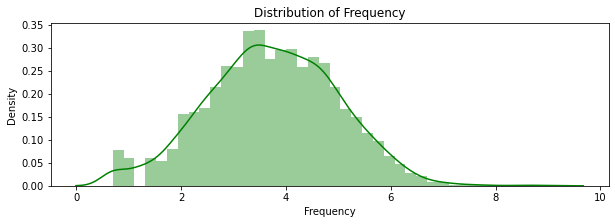

Monetary's: Skew: 0.3860246163588398, : SkewtestResult(statistic=10.04517488363482, pvalue=9.647639756640075e-24)


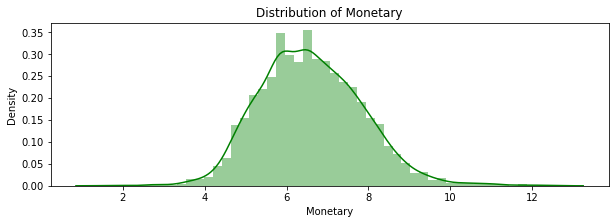

In [298]:
# Make a copy of the DataFrame
# 
RFM_log = RFM[ ['Recency', 'Frequency', 'Monetary']].copy()

# Log features
#
VALUE = max(0, -RFM_log.min().min()) + 1
RFM_log = np.log(RFM_log + VALUE)


# Plot all Distrubution graphs of Recency, Frequency & Monetary
#
check_skew(RFM_log, 'Recency');

check_skew(RFM_log, 'Frequency');

check_skew(RFM_log, 'Monetary');

#### Winsorizing

Winsorizing or winsorization is the transformation of statistics by limiting extreme values in the statistical data to reduce the effect of possibly spurious outliers. It is named after the engineer-turned-biostatistician Charles P. Winsor (1895–1951). The effect is the same as clipping in signal processing.

In [299]:
windsoriser = Winsorizer(tail      = 'both', # cap left, right or both tails 
                         fold      = 2,
                         variables = [ 'Recency', 'Frequency', 'Monetary']
                        )

windsoriser.fit( RFM_log )

RFM_log = windsoriser.transform( RFM_log )

### Standarization

Once the skewness is reduced, I standardised the data by centring and scaling. Note all the variables now have a mean of 0 and a standard deviation of 1.

In [300]:
# Setup scaler
# 
scaler = StandardScaler()

# Fit scaler
scaler.fit( RFM_log )

RFM_log_scaled = pd.DataFrame(data    = scaler.transform(RFM_log), 
                              columns = RFM_log.columns)

### K-Means clustering process

### Finding the optimal number of clusters

In [301]:
from scipy.spatial.distance import cdist
from sklearn.metrics        import silhouette_score

distortions = [] 
inertias    = [] 
Clusters    = [ [] ]
Centroids   = [ [] ]
K = range(1, 11)
  
for k in K: 
    # Setup K-Means model     
    model = KMeans(n_clusters = k, random_state = 42)
    
    # Fit model
    model.fit( RFM_log_scaled )     

    # Store clusters
    Clusters  += [ model.labels_.tolist() ]
    
    # Get centroids
    Centroids += [ model.cluster_centers_ ]

    # Calculate distortions
    distortions.append( sum(np.min(cdist(RFM_log_scaled, model.cluster_centers_, 'euclidean'), axis = 1)) / RFM_log_scaled.shape[0] ) 

    # Calculate inertias
    inertias.append( model.inertia_ ) 
  
    # Calculate Silhouette score
    if (k > 1):
        Sil = silhouette_score(X     = RFM_log_scaled, 
                              labels = model.labels_)

        print('K = %2i Silhouette Score %.3f' % (k, Sil))
    

K =  2 Silhouette Score 0.407
K =  3 Silhouette Score 0.300
K =  4 Silhouette Score 0.317
K =  5 Silhouette Score 0.282
K =  6 Silhouette Score 0.286
K =  7 Silhouette Score 0.272
K =  8 Silhouette Score 0.264
K =  9 Silhouette Score 0.265
K = 10 Silhouette Score 0.273


#### Elbow Method using Distortion and Inertia

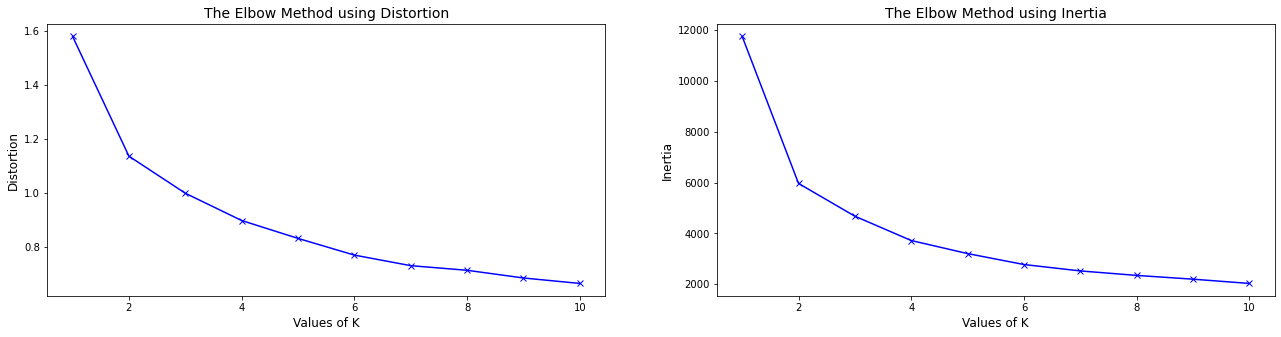

In [33]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (22, 5) )
#
ax[0].plot(K, distortions, 'bx-') 
ax[0].set_xlabel('Values of K', size = 12) 
ax[0].set_ylabel('Distortion', size = 12) 
ax[0].set_title('The Elbow Method using Distortion', size = 14) 
#
ax[1].plot(K, inertias, 'bx-') 
ax[1].set_xlabel('Values of K', size = 12) 
ax[1].set_ylabel('Inertia', size = 12) 
ax[1].set_title('The Elbow Method using Inertia', size = 14)
#
#
plt.show();


#### Cluster visualization

In [34]:
import umap

UMAP_arg    = { 'n_neighbors': 30, 
                'min_dist':    0.01 }

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Apply UMAP
#
umapModel = umap.UMAP(n_neighbors  = UMAP_arg['n_neighbors'],
                      min_dist     = UMAP_arg['min_dist'],
                      n_components = 2,
                      random_state = 42)

embeddings = umapModel.fit_transform( RFM_log_scaled[ ['Recency', 'Frequency', 'Monetary']].to_numpy() )

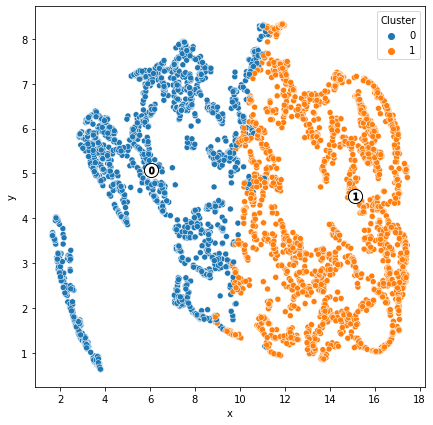

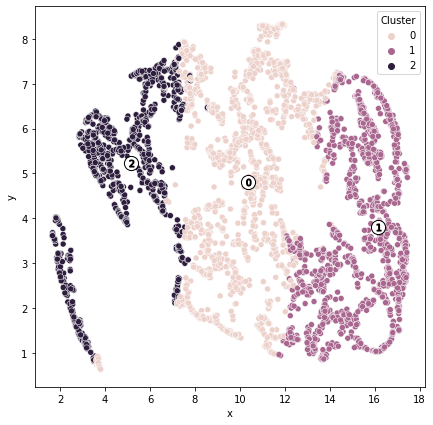

In [35]:
# Create DataFrame
# 
clustering_df = pd.DataFrame( embeddings, columns = ['x', 'y'] )

for k in [2, 3]:
    # Get Cluster    
    clustering_df['Cluster'] = Clusters[k]


    # Clustering visualization in 2D
    #
    plt.figure( figsize = (7, 7) )
    sns.scatterplot(data = clustering_df, x = 'x', y = 'y', hue = 'Cluster')

    # Plot centroids
    #
    centers = umapModel.transform( Centroids[ k ] )
    plt.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate( centers ):
            plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s = 50, edgecolor='k')

#### Snake plots

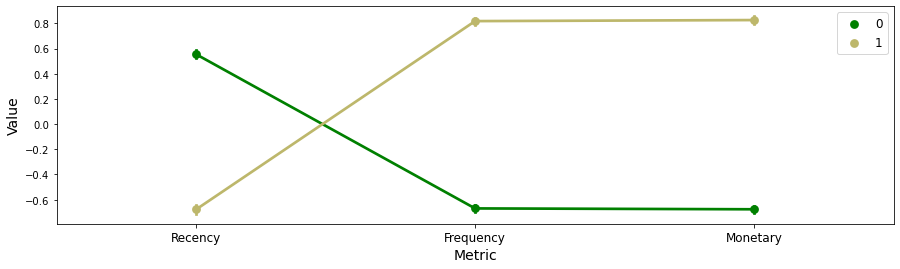

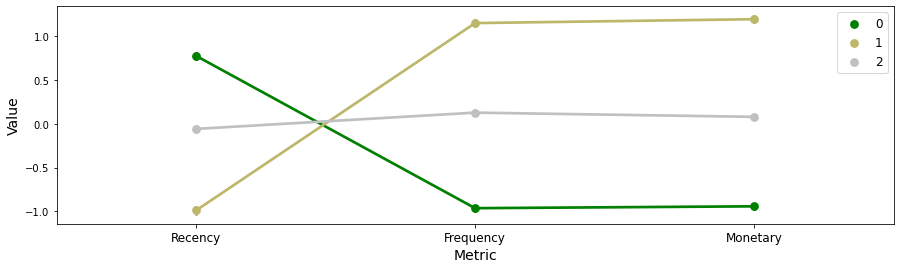

In [302]:
for k in [2, 3]:
    snake_plot(RFM_log_scaled.copy(), Clusters[k], RFM['CustomerID'])

### Clustering evaluation

- Silhouette visualizer

In [303]:
# Selected number of clusters
# 
n_clusters = 3

# Setup model
model = KMeans(n_clusters = n_clusters).fit( RFM_log_scaled ) 

# Fit model
model.fit( RFM_log_scaled )     

# Get Clustering-Results
RFM[ 'Cluster' ] = model.labels_

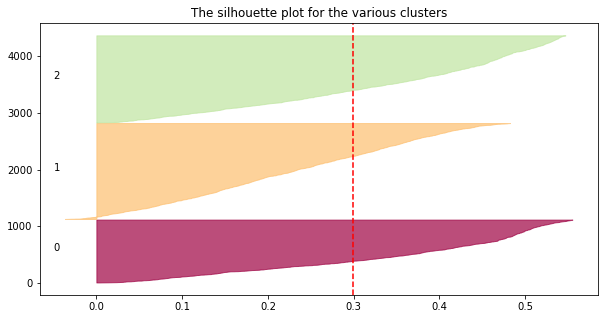

In [304]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

plt.figure( figsize = (10, 5))


Sil = silhouette_score(X      = RFM_log_scaled, 
                       labels = RFM[ 'Cluster' ])


sample_silhouette_values = silhouette_samples(X = RFM_log_scaled, labels = RFM['Cluster'])

y_lower = 10
for i in range( n_clusters ):
    ith_cluster_silhouette_values = sample_silhouette_values[ RFM['Cluster'] == i ]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.Spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples
    
    
plt.axvline(x = Sil, color="red", linestyle="--")

# Set figure title
#
plt.title('The silhouette plot for the various clusters');

### Interpretation of the clusters formed using k-means
 

In [305]:
RFM.groupby(['Cluster']).agg({'Recency'   : 'mean',
                              'Frequency' : 'mean',
                              'Monetary'  :  ['mean', 'count']})

Recency   Frequency     Monetary      
               mean        mean         mean count
Cluster                                           
0         24.545537  246.593327  5834.477313  1109
1         79.562648   59.028960  1125.304949  1692
2        195.208984   15.972656   299.331374  1536

CustomerID
Cluster Score               
0       Bronze            27
        Green           1082
1       Bronze           660
        Gold               4
        Green            181
        Silver           847
2       Gold             382
        Platinum         897
        Silver           257

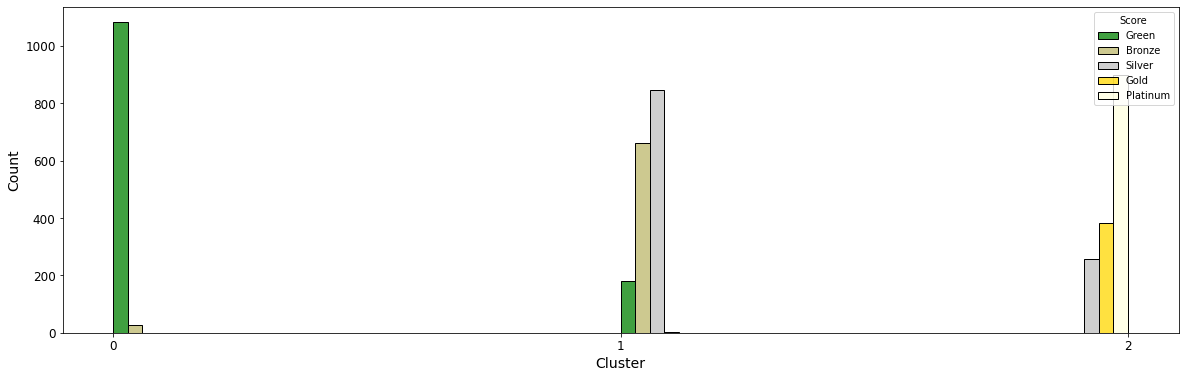

In [306]:
# Create an array with the colors you want to use
colors = ["green", "darkkhaki", "silver", "gold",  "lightyellow"]

# Set your custom color palette
sns.set_palette( sns.color_palette(colors) )



plt.figure( figsize = (20, 6) )
#
#
sns.histplot(data = RFM, x = 'Cluster', hue = 'Score', multiple="dodge", )
#
plt.xticks( np.arange(n_clusters), size = 12 );
plt.yticks( size = 12 );
#
plt.xlabel('Cluster', size = 14);
plt.ylabel('Count',   size = 14);

RFM.groupby(['Cluster', 'Score']).count()[ ['CustomerID'] ]

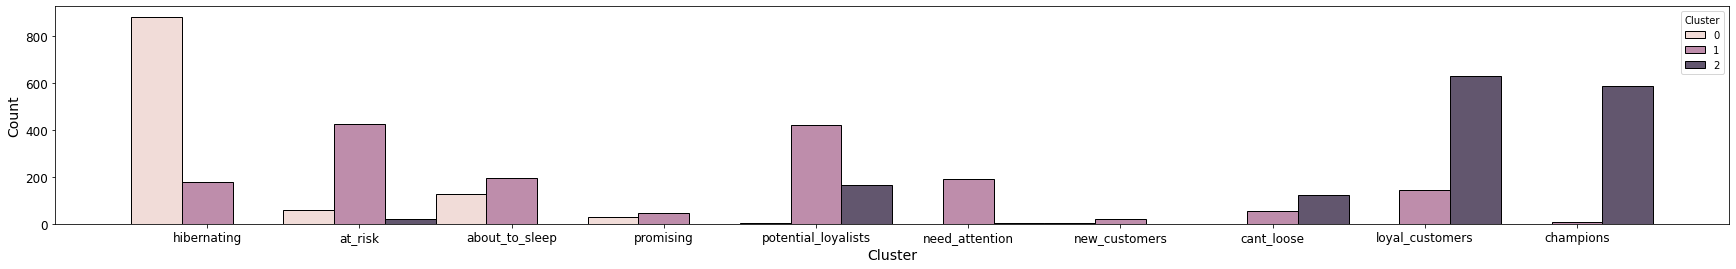

In [307]:
# Create an array with the colors you want to use
# colors = ["green", "darkkhaki", "silver", "gold",  "lightyellow"]

# Set your custom color palette
# sns.set_palette( sns.color_palette(colors) )



plt.figure( figsize = (30, 4) )
#
#
g = sns.histplot(data = RFM, hue = 'Cluster', x = 'Segment', multiple = 'dodge', color = "lime")
#
plt.xticks( size = 12 );
plt.yticks( size = 12 );
#
plt.xlabel('Cluster', size = 14);
plt.ylabel('Count',   size = 14);


# RFM.groupby(['Cluster', 'Segment']).count()[ ['CustomerID'] ]

In [42]:
asd

NameError: name 'asd' is not defined

# Customer Life-Time Value

<!-- <p align="center"> -->
<img src="images/CLTV.png" alt="drawing" width="1000"/>

## Calculate CLTV

In [308]:
def create_cltv_calculated( RFM ):

    dataframe = RFM.copy()
    # avg_order_value
    dataframe['avg_order_value'] = dataframe['Monetary'] / dataframe['Frequency']

    # purchase_frequency
    dataframe["purchase_frequency"] = dataframe['Frequency'] / dataframe.shape[0]

    # repeat rate & churn rate
    repeat_rate = dataframe[dataframe['Frequency'] > 1].shape[0] / dataframe.shape[0]
    churn_rate = 1 - repeat_rate

    # profit_margin
    dataframe['profit_margin'] = dataframe['Monetary'] * 0.05

    # Customer Value
    dataframe['cv'] = (dataframe['avg_order_value'] * dataframe["purchase_frequency"])

    # Customer Lifetime Value
    dataframe['CLTV'] = (dataframe['cv'] / churn_rate) * dataframe['profit_margin']

    # MinMax-scaling
    #
    # Setup scaler
    scaler = MinMaxScaler(feature_range=(1, 100))
    # Apply scaler
    dataframe["CLTV_calculated"] = scaler.fit_transform(dataframe[["CLTV"]])

    # Calculate CLTV segments
    dataframe["CLTV_calculated_segment"] = pd.qcut(dataframe["CLTV_calculated"], 4, labels = ['D', 'C', 'B', 'A'])

    dataframe = dataframe[["Recency", "Frequency", "Monetary", "Segment", "CLTV_calculated", "CLTV_calculated_segment"]]

    return dataframe


cltv_df = create_cltv_calculated(RFM.copy())

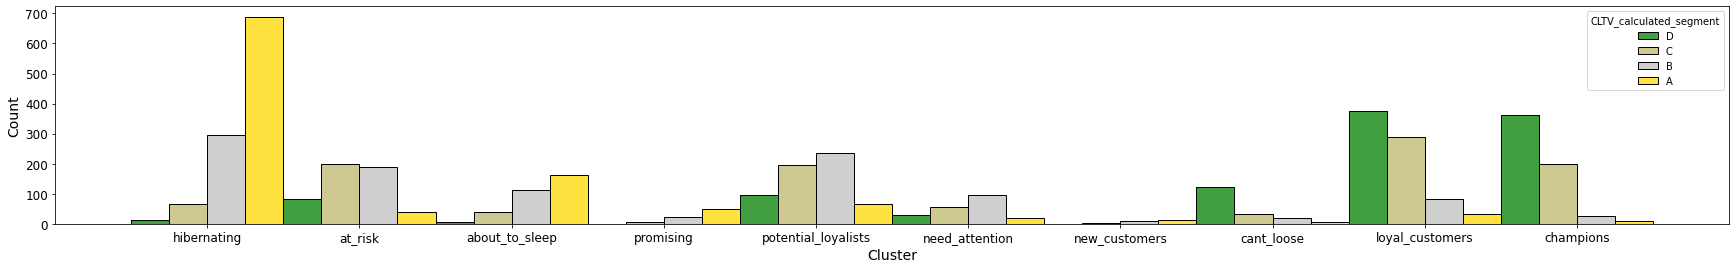

In [309]:
plt.figure( figsize = (30, 4) )
#
#
g = sns.histplot(data = cltv_df, hue = 'CLTV_calculated_segment', x = 'Segment', multiple = 'dodge', color = "lime")
#
plt.xticks( size = 12 );
plt.yticks( size = 12 );
#
plt.xlabel('Cluster', size = 14);
plt.ylabel('Count',   size = 14);

## CLTV Predicted


- What is a cohort model?

Instead of simply assuming all the customers to be one group, we can try to split them into multiple groups and calculate the CLTV for each group.

Note: recency value customized. (One of the key differences between RFM and CLTV)

<br />

**Beta Geometric / Negative Binomial Distribution (BG-NBD)**

In short, expected sales value. Used to estimate how many purchases customers can make over a period of time

This method computes the probability that a customer with history (frequency, recency_weekly, T_weekly) is currently alive (relationship between recency & frequency).

**Gamma Gamma**

-conditional expected number of purchases up to time-

<br />
<br />

Notes: 
1. There should be no correlation between the frequency of transactions and their monetary value.
2. We are considering only customers who made repeat purchases with the business i.e., frequency > 0. Because, if the frequency is 0, it means that they are a one-time customer and are considered already dead.


In [310]:
today_date = dt.date(2012, 12, 11)

cltv_df = df.groupby('CustomerID').agg(
    {'Date':      [ lambda date: (date.max() - date.min()).days,
                    lambda date: (today_date - date.min()).days ],
     'InvoiceNo':   lambda num: num.nunique(),
     'Revenue':     lambda Revenue: Revenue.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)

cltv_df.columns = ['Recency', 'T', 'Frequency', 'Monetary']

In [311]:
# Calculate Average Monetary
# 
cltv_df["Monetary_avg"] = cltv_df["Monetary"] / cltv_df["Frequency"]
cltv_df.drop(['Monetary'], axis = 1, inplace = True) # Not needed any more


# Recency filter
#
cltv_df = cltv_df[(cltv_df['Frequency'] > 1)]


# Tenure on weekly scale
#
cltv_df["Recency"] = cltv_df["Recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7  

### Basic Frequency/Recency analysis using the BG/NBD model

In [312]:
from lifetimes             import BetaGeoFitter

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# BG/NBD Model
#

# Setup model
bgf = BetaGeoFitter(penalizer_coef = 1e-1)

# Fit model
bgf.fit(frequency = cltv_df['Frequency'],
        recency   = cltv_df['Recency'],
        T         = cltv_df['T'])

print('[INFO] BG/NBD model trained')

[INFO] BG/NBD model trained


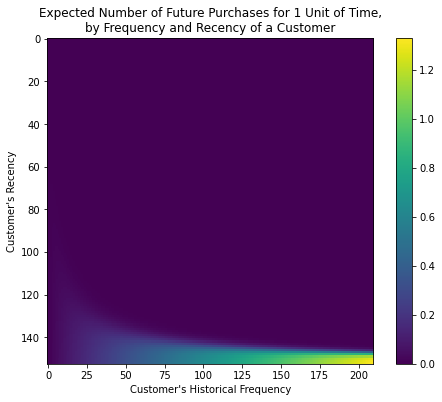

In [313]:
from lifetimes.plotting import plot_frequency_recency_matrix

plt.figure( figsize = (8, 6) )
plot_frequency_recency_matrix( bgf );

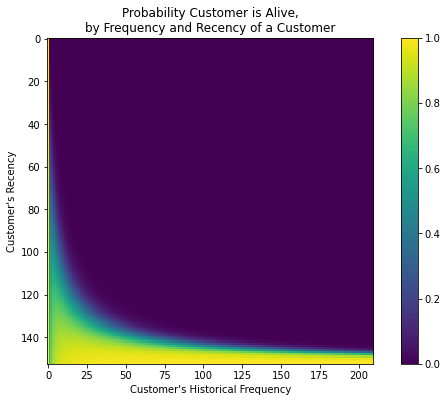

In [314]:
from lifetimes.plotting import plot_probability_alive_matrix

plt.figure( figsize = (10, 6) )
plot_probability_alive_matrix( bgf );

**Findings:** 

- If a customer has bought 200 times from you (Frequency), and their latest purchase was when they were 75 weeks old (Recency), then they are your best customer (bottom-right). 

- The coldest customers are those that are in the top-right corner: they bought a lot quickly, and we haven’t seen them in weeks.

- There’s also that beautiful “tail” around (50, 80). That represents the customer who buys infrequently, but we’ve seen him or her recently, so they might buy again - we’re not sure if they are dead or just between purchases.

#### Assessing model fit

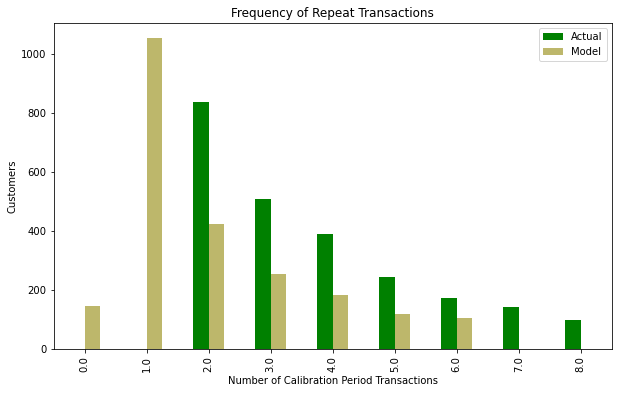

In [315]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions( bgf, figsize = (10, 6) );

#### Top 10 customers expected to make the most purchases in a week


In [316]:
bgf.conditional_expected_number_of_purchases_up_to_time(t         = 1, # 4 weeks = 1 month
                                                        frequency = cltv_df['Frequency'],
                                                        recency   = cltv_df['Recency'],
                                                        T         = cltv_df['T']).sort_values(ascending = False).head(10)

CustomerID
14307    0.017026
16150    0.016350
14696    0.016350
12868    0.016217
13520    0.015891
17685    0.015621
13448    0.015417
12433    0.015382
16203    0.015356
14741    0.015254
dtype: float64

#### Top 10 customers expected to make the most purchases in a month


In [317]:
bgf.conditional_expected_number_of_purchases_up_to_time(t         = 4, # 4 weeks = 1 month
                                                        frequency = cltv_df['Frequency'],
                                                        recency   = cltv_df['Recency'],
                                                        T         = cltv_df['T']).sort_values(ascending = False).head(10)

CustomerID
14307    0.067724
14696    0.065037
16150    0.065024
12868    0.064508
13520    0.063191
17685    0.062130
13448    0.061325
12433    0.061186
16203    0.061067
14741    0.060666
dtype: float64

#### Top 10 customers expected to make the most purchases in next 6 months & total amount of transactions

In [318]:
bgf.conditional_expected_number_of_purchases_up_to_time(t         = 4*6, # 4*6 weeks = 6 months
                                                        frequency = cltv_df['Frequency'],
                                                        recency   = cltv_df['Recency'],
                                                        T         = cltv_df['T']).sort_values(ascending = False).head(10)

CustomerID
14307    0.392285
14696    0.376790
16150    0.376194
12868    0.373657
13520    0.365349
17685    0.359609
13448    0.355221
12433    0.354480
16203    0.353189
14741    0.351065
dtype: float64

In [319]:
print('[INFO] Total amount of transactions = %.2f' % 
        bgf.conditional_expected_number_of_purchases_up_to_time(t         = 4*6, # 4*6 weeks = 6 months
                                                                frequency = cltv_df['Frequency'],
                                                                recency   = cltv_df['Recency'],
                                                                T         = cltv_df['T']).sum())

[INFO] Total amount of transactions = 173.33


### Gamma Gamma model

In [320]:
from lifetimes             import GammaGammaFitter

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Gamma Gamma model
#

# Setup model
ggf = GammaGammaFitter(penalizer_coef=0.01)

# Fit model
ggf.fit(frequency      = cltv_df['Frequency'], 
        monetary_value = cltv_df['Monetary_avg'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.72>

#### The top 10 customers expected to be most valuable

In [321]:
ggf.conditional_expected_average_profit(frequency      = cltv_df['Frequency'],
                                        monetary_value = cltv_df['Monetary_avg']).sort_values(ascending = False).head(10)

CustomerID
16446    92301.045393
15749    15764.049779
15098    14129.598375
12415     5998.391712
12590     5406.251728
12536     4461.682756
16000     4388.015994
18102     4340.321923
12435     4291.705841
17450     4245.570683
dtype: float64

### Prediction of CLTV using BG/NBD and Gamma Gamma models

In [322]:
discount_rate = 0.01

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['Frequency'],
                                   cltv_df['Recency'],
                                   cltv_df['T'],
                                   cltv_df['Monetary_avg'],
                                   time          = 6,
                                   freq          = "W",
                                   discount_rate = discount_rate)

# Reset index
cltv = cltv.reset_index()
# cltv_final = cltv_df.merge(cltv, on="CustomerID", how="left")

# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(cltv_final[["clv"]])
# cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])

In [323]:
cltv.shape, cltv_df.shape

((2845, 2), (2845, 4))

In [324]:
cltv_df.head( 5 )

,Recency,T,Frequency,Monetary_avg
CustomerID,,,,
12347,68.000000,126.142857,7,615.714286
12348,40.428571,103.714286,4,449.310000
12352,38.285714,101.142857,8,313.255000
12356,43.285714,99.000000,3,937.143333
12358,16.714286,69.571429,2,584.030000


In [225]:
def add_clv(final_df, df_, month: int):
    cltv = ggf.customer_lifetime_value(bgf,
                                       df_['Frequency'],
                                       df_['Recency'],
                                       df_['T'],
                                       df_['Monetary_avg'],
                                       time=month,
                                       freq="W",
                                       discount_rate = discount_rate)

    cltv = cltv.reset_index()
    cltv.rename(columns={'clv': f'{month}m_clv'}, inplace=True)
    final = final_df.merge(cltv, on='CustomerID', how='left')
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(final[[f"{month}m_clv"]])
    final[f"{month}m_scaled_clv"] = scaler.transform(final[[f"{month}m_clv"]])
    return final

In [226]:
final = RFM[['CustomerID', 'Segment']].merge(cltv_final, on = 'CustomerID') # Merging RFM
final.rename(columns={'scaled_clv': '6m_scaled_clv', 'clv': '6m_clv'},
             inplace=True)

final = add_clv(final, cltv_df, 1)
final = add_clv(final, cltv_df, 12)

In [227]:
final.head( 4 )

,CustomerID,Segment,Recency,T,Frequency,Monetary_avg,6m_clv,6m_scaled_clv,1m_clv,1m_scaled_clv,12m_clv,12m_scaled_clv
0,16409,hibernating,45.000000,97.857143,5,405.776000,61.020042,0.015380,208.276420,0.006487,2354.278561,0.006508
1,15570,hibernating,80.857143,134.857143,12,347.126667,28.396643,0.007157,220.741665,0.006875,2501.047553,0.006914
2,17211,hibernating,81.857143,134.857143,8,289.652500,74.935495,0.018888,128.892628,0.004015,1460.143222,0.004036
3,18283,hibernating,44.428571,98.285714,16,130.930000,0.053418,0.000013,182.876419,0.005696,2068.739724,0.005719


**CLTV Segmentation**

Since we try to create better segmentation and marketing strategies based on RFM and CLTV we will also create segments based on our CLTV. ‘A’ for our best customers and ‘D’ for the worst.

In [228]:
final["cltv_segment"] = pd.qcut(final["6m_scaled_clv"], 4, labels=["D", "C", "B", "A"])

final.head( 5 )


,CustomerID,Segment,Recency,T,Frequency,Monetary_avg,6m_clv,6m_scaled_clv,1m_clv,1m_scaled_clv,12m_clv,12m_scaled_clv,cltv_segment
0,16409,hibernating,45.000000,97.857143,5,405.776000,61.020042,0.015380,208.276420,0.006487,2354.278561,0.006508,A
1,15570,hibernating,80.857143,134.857143,12,347.126667,28.396643,0.007157,220.741665,0.006875,2501.047553,0.006914,B
2,17211,hibernating,81.857143,134.857143,8,289.652500,74.935495,0.018888,128.892628,0.004015,1460.143222,0.004036,A
3,18283,hibernating,44.428571,98.285714,16,130.930000,0.053418,0.000013,182.876419,0.005696,2068.739724,0.005719,D
4,17218,hibernating,76.285714,130.428571,10,196.072000,23.633464,0.005957,111.519340,0.003473,1263.272770,0.003492,B


CustomerID
cltv_segment Segment                        
D            about_to_sleep               53
             at_risk                      35
             cant_loose                   15
             champions                    66
             hibernating                 232
             loyal_customers              68
             need_attention               15
             new_customers                14
             potential_loyalists         122
             promising                    23
C            about_to_sleep               72
             at_risk                      75
             cant_loose                   19
             champions                    23
             hibernating                 182
             loyal_customers              97
             need_attention               33
             new_customers                 1
             potential_loyalists         124
             promising                    16
B            about_to_sleep               85
             at_risk                     102
             cant_loose                   18
             champions                     8
             hibernating                 215
             loyal_customers              72
             need_attention               45
             new_customers                 0
             potential_loyalists          85
             promising                    12
A            about_to_sleep               71
             at_risk                     140
             cant_loose                   21
             champions                     2
             hibernating                 297
             loyal_customers              31
             need_attention               35
             new_customers                 1
             potential_loyalists          32
             promising                    13

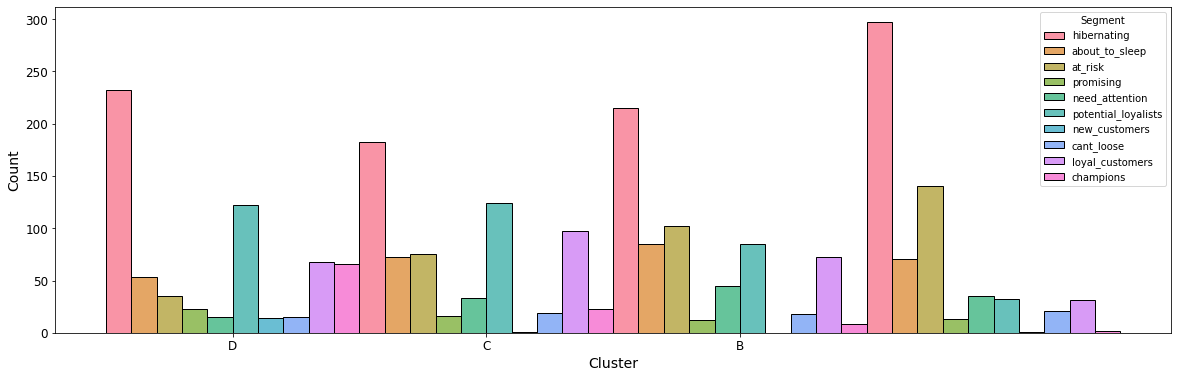

In [229]:
plt.figure( figsize = (20, 6) )
#
#
sns.histplot(data = final, x = 'cltv_segment', hue = 'Segment', multiple="dodge")
#
plt.xticks( np.arange(n_clusters), size = 12 );
plt.yticks( size = 12 );
#
plt.xlabel('Cluster', size = 14);
plt.ylabel('Count',   size = 14);

final.groupby(['cltv_segment', 'Segment']).count()[ ['CustomerID'] ]


In [232]:
d = {'cltv_segment':[], 'Segment':[], 'value':[]}
for cltv_segment in ['A', 'B', 'C', 'D']:
    for segment in final['Segment'].unique():
        value = 100.0 * final[ (final['Segment'] == segment) & (final['cltv_segment'] == cltv_segment)].shape[0] / final[ (final['Segment'] == segment) ].shape[0]

        d['cltv_segment'] += [cltv_segment]
        d['Segment']      += [segment]
        d['value']        += [value]


<AxesSubplot:xlabel='Segment', ylabel='Count'>

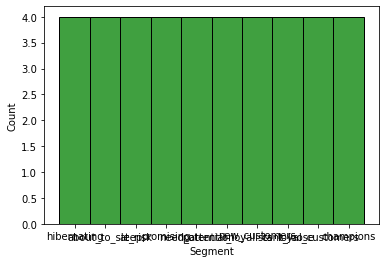

In [237]:
A = pd.DataFrame(d)

# A.groupby(['Segment', 'cltv_segment']).max()[ ['value'] ]

sns.histplot(data = A,  x = 'Segment', multiple="dodge")


In [240]:
A.groupby(['Segment', 'cltv_segment']).max()[ ['value'] ]

value
Segment             cltv_segment           
about_to_sleep      A             25.266904
                    B             30.249110
                    C             25.622776
                    D             18.861210
at_risk             A             39.772727
                    B             28.977273
                    C             21.306818
                    D              9.943182
cant_loose          A             28.767123
                    B             24.657534
                    C             26.027397
                    D             20.547945
champions           A              2.020202
                    B              8.080808
                    C             23.232323
                    D             66.666667
hibernating         A             32.073434
                    B             23.218143
                    C             19.654428
                    D             25.053996
loyal_customers     A             11.567164
                    B             26.865672
                    C             36.194030
                    D             25.373134
need_attention      A             27.343750
                    B             35.156250
                    C             25.781250
                    D             11.718750
new_customers       A              6.250000
                    B              0.000000
                    C              6.250000
                    D             87.500000
potential_loyalists A              8.815427
                    B             23.415978
                    C             34.159780
                    D             33.608815
promising           A             20.312500
                    B             18.750000
                    C             25.000000
                    D             35.937500